Best number of components: 3


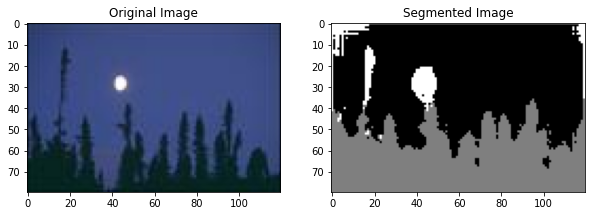

In [30]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.transform import resize


image_path = 'test12.jpg'
image = imread(image_path)

#downsample it to reduce computational needs
#downsampled_image = resize(image, (image.shape[0] // 2, image.shape[1] // 2), anti_aliasing=True)
downsampled_image = image;


def preprocess_image(image):
    nrows, ncols, nchannels = image.shape
    X = np.c_[np.indices((nrows, ncols)).reshape(2, -1).T, image.reshape(-1, nchannels)]
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    return X_normalized

X_normalized = preprocess_image(downsampled_image)

# cross-validation for GMM
def gmm_cross_validation(X, n_splits=10):
    kf = KFold(n_splits=n_splits)
    scores = []
    
    for n_components in range(1, 11):
        model = GaussianMixture(n_components=n_components, covariance_type='full')
        fold_scores = [] 
        for train_index, test_index in kf.split(X):
            model.fit(X[train_index])
        
            score = model.score(X[test_index])
            fold_scores.append(score)
        
        scores.append(np.mean(fold_scores))
    
    best_n_components = np.argmax(scores) + 1 
    return best_n_components

# the best model
best_n_components = gmm_cross_validation(X_normalized)
print(f'Best number of components: {best_n_components}')

# Fit the best GMM model
gmm = GaussianMixture(n_components=best_n_components, covariance_type='full', random_state=0)
gmm.fit(X_normalized)
posterior_probs = gmm.predict_proba(X_normalized)

loss_matrix = np.ones((best_n_components, best_n_components)) - np.eye(best_n_components)
expected_risks = np.dot(loss_matrix, posterior_probs.T)
labels = np.argmin(expected_risks, axis=0)

# Map labels to a range that ensures good contrast
unique_labels = np.unique(labels)
min_gray, max_gray = 0, 255

grayscale_map = np.linspace(min_gray, max_gray, len(unique_labels), endpoint=True).astype(int)
grayscale_labels = np.array([grayscale_map[label] for label in labels])
segmented_image = grayscale_labels.reshape(downsampled_image.shape[0], downsampled_image.shape[1])
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(122)
plt.imshow(segmented_image, cmap='gray')  # Use a colormap that displays the clusters well
plt.title('Segmented Image')
plt.show()